# 7장. 시계열 데이터를 다뤄보자
<분석 목적>
- 페이스북에서 만든 ```fbprophet```이라는 모듈을 사용하여, 시계열 예측을 수행해보고자 한다
    - ```fbprophet```이라는 모듈을 사용하려면, 윈도우 유저들은 먼저 **Visual C++ Build Tools**를 설치해야 한다
    - 그리고 cmd 창에서 ```pip install pystan```과 ```pip install prophet```을 수행해야 한다
        - 난 설치 실패로 인해 ```pip install pystan``` 대신, ```conda install -c conda-forge fbprophet```과 ```pip install plotly```를 수행하였다
    - 추가적으로 cmd 창에서 ```pip install pandas_datareader``` 명령을 수행해서 **pandas_datareader**도 설치해줘야 한다 
        
<데이터 설명>
- https://goo.gl/5wWzLL 에서 **"08. PinkWink Web Tracffic.csv"** 데이터를 다운 받아서 사용했다
    - 해당 데이터는 저자 블로그의 **"웹 트래픽"** 관련 데이터이다

## Numpy의 polyfit으로 회귀(Regression) 분석하기

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from fbprophet import Prophet
from datetime import datetime

**```matplotlib```에서 한글 폰트 문제를 해결해주기 위한 코드**

In [2]:
path = "c:/Windows/Fonts/malgun.ttf"
import platform
from matplotlib import font_manager, rc
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname = path).get_name()
    rc('font', family = font_name)
else:
    print('Unknown system... sorry~~~~')    

plt.rcParams['axes.unicode_minus'] = False

In [3]:
pinkwink_web = pd.read_csv("../data/08. PinkWink Web Traffic.csv",
                           encoding = 'utf-8', thousands = ',',
                           names = ['date', 'hit'], index_col = 0)
pinkwink_web = pinkwink_web[pinkwink_web['hit'].notnull()]
pinkwink_web.head()

,hit
date,
16. 7. 1.,766.0
16. 7. 2.,377.0
16. 7. 3.,427.0
16. 7. 4.,902.0
16. 7. 5.,850.0


**2016년 7월 1일부터 2017년 6월 16일까지의 유입량을 그려보았다**
- 이렇게만 봐서는 **주기성**이 존재하는지에 대한 여부를 정확하게 알 수 없다

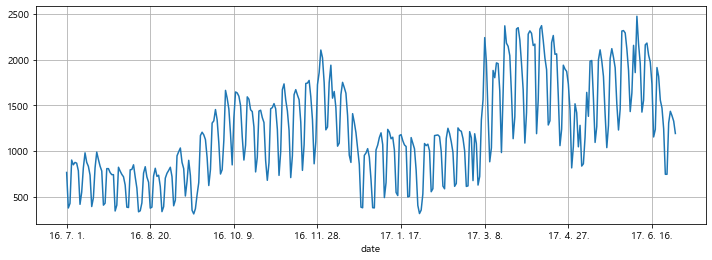

In [4]:
pinkwink_web['hit'].plot(figsize = (12, 4), grid = True);

**위 그래프에 대한 '선형 회귀 직선' 및 '다항 회귀식'을 표현해보려 한다**
- 회귀 모델을 1차, 2차, 3차, 15차 다항식으로 표현하고, 결과를 확인해보겠다

In [5]:
time = np.arange(0, len(pinkwink_web)) # 시간축(time) 생성 (0부터 365까지)
traffic = pinkwink_web['hit'].values   # 웹 트래픽의 자료를 traffic 변수에 저장

fx = np.linspace(0, time[-1], 1000)    # 0부터 364까지를 1000개로 분할

- **RMSE(Root Mean Square Error)**을 계산해주는 ```error()``` 함수를 생성

In [6]:
def error(f, x, y):
    return np.sqrt(np.mean((f(x) - y) ** 2)) # RMSE(Root Mean Square Error)

- 각 차수별 다항식의 **'RMSE(Root Mean Square Error)'**을 계산하고, 결과를 시각화
    - 1차, 2차, 3차 다항식의 RMSE(Root Mean Square Error)는 거의 비슷한 반면, 15차 다항식의 RMSE(Root Mean Square Error)는 비교적 낮은 것을 알 수 있다
    - 이는 모델이 복잡해질수록 주어진 데이터에 대한 fitting 정확도가 높아지기 때문이다 (단, **모델이 너무 복잡**하면 **과적합(overfitting)** 문제가 발생할 수 있다!!)

<참고>
- Numpy의 polyfit, poly1d의 사용법 관련 참고 사이트: https://pinkwink.kr/1127

In [7]:
# 1차 다항식
fp1 = np.polyfit(time, traffic, 1)
f1 = np.poly1d(fp1)

# 2차 다항식
f2p = np.polyfit(time, traffic, 2)
f2 = np.poly1d(f2p)

# 3차 다항식
f3p = np.polyfit(time, traffic, 3)
f3 = np.poly1d(f3p)

# 15차 다항식
f15p = np.polyfit(time, traffic, 15)
f15 = np.poly1d(f15p)

# 각 차수별 다항식의 '잔차 제곱합'을 계산
print(error(f1, time, traffic))
print(error(f2, time, traffic))
print(error(f3, time, traffic))
print(error(f15, time, traffic))

430.85973081109626
430.6284101894695
429.53280466762925
330.4777304274343


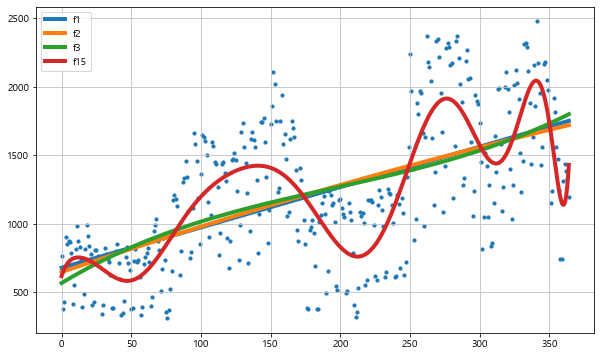

In [8]:
plt.figure(figsize = (10, 6))
plt.scatter(time, traffic, s = 10)

plt.plot(fx, f1(fx), lw = 4, label = 'f1')
plt.plot(fx, f2(fx), lw = 4, label = 'f2')
plt.plot(fx, f3(fx), lw = 4, label = 'f3')
plt.plot(fx, f15(fx), lw = 4, label = 'f15')

plt.grid(True, linestyle = '-', color = '0.75')

plt.legend(loc = 2)
plt.show()

## Prophet 모듈을 이용한 forecast 예측
- 먼저 pinkwink_web 변수에서 날짜(index), 방문수(hit)만 따로 저장하겠다
- 그리고 ```pandas```의 ```to_datetime()``` 함수를 사용해서 'ds' 변수를 날짜로 선언해주겠다
- 마지막으로 ```Prophet()``` 함수를 사용할 때, **주기성이 연단위(yearly_seasonality) 및 일단위(daily_seasonality)**로 있다고 알려준다

In [9]:
df = pd.DataFrame({'ds': pinkwink_web.index, 'y': pinkwink_web['hit']})
df.reset_index(inplace = True)

df['ds'] = pd.to_datetime(df['ds'], format = "%y. %m. %d.") # "yyyy-mm-dd" 형태로 변경

# 'ds' 변수를 생성해줬으므로, 'date' 변수는 삭제
del df['date']

m = Prophet(yearly_seasonality = True, daily_seasonality = True)
m.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


**```make_future_dataframe()```로 지정된 날짜 수만큼 미래로 확장하는 적절한 데이터 프레임 얻기**
- 즉, 여기서는 60일 간의 데이터를 예측하고 싶다고 설정해준 것이다!

In [10]:
future = m.make_future_dataframe(periods = 60)
future.tail()

,ds
420,2017-08-25
421,2017-08-26
422,2017-08-27
423,2017-08-28
424,2017-08-29


**```predict()```를 사용하여 예측한 데이터를 forecast 변수에 저장**

In [11]:
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-07-01,824.576922,502.632088,946.950792,824.576922,824.576922,-94.335613,-94.335613,-94.335613,236.084315,...,-51.467790,-51.467790,-51.467790,-278.952139,-278.952139,-278.952139,0.0,0.0,0.0,730.241309
1,2016-07-02,825.416679,78.304003,511.903625,825.416679,825.416679,-525.935009,-525.935009,-525.935009,236.084315,...,-467.268743,-467.268743,-467.268743,-294.750582,-294.750582,-294.750582,0.0,0.0,0.0,299.481669
2,2016-07-03,826.256435,211.423174,631.597398,826.256435,826.256435,-406.571231,-406.571231,-406.571231,236.084315,...,-335.184312,-335.184312,-335.184312,-307.471234,-307.471234,-307.471234,0.0,0.0,0.0,419.685205
3,2016-07-04,827.096192,744.344249,1163.872565,827.096192,827.096192,135.972339,135.972339,135.972339,236.084315,...,217.224608,217.224608,217.224608,-317.336584,-317.336584,-317.336584,0.0,0.0,0.0,963.068531
4,2016-07-05,827.935949,773.450382,1199.634274,827.935949,827.935949,164.825671,164.825671,164.825671,236.084315,...,253.352629,253.352629,253.352629,-324.611273,-324.611273,-324.611273,0.0,0.0,0.0,992.761620


- 확인해보고자 하는 변수들만 뽑아내서 확인
    - **'ds', 'yhat', 'yhat_lower', 'yhat_upper'** 변수들만 뽑아냈다

In [12]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
420,2017-08-25,911.790860,687.739352,1123.165010
421,2017-08-26,496.917939,299.881040,719.876299
422,2017-08-27,629.458439,424.561921,838.188886
423,2017-08-28,1181.938386,961.211611,1382.032678
424,2017-08-29,1217.864960,1006.304637,1433.076587


- 시각화를 통해 예측 결과를 확인
    - 2017년 6월 말까지의 데이터 이후, 약 2개월(60일)의 예측 결과를 볼 수 있다
    - 앞서 수행한 것처럼 단순히 다항식으로 경향을 파악하는 것보다 더 효과적인 것 같다

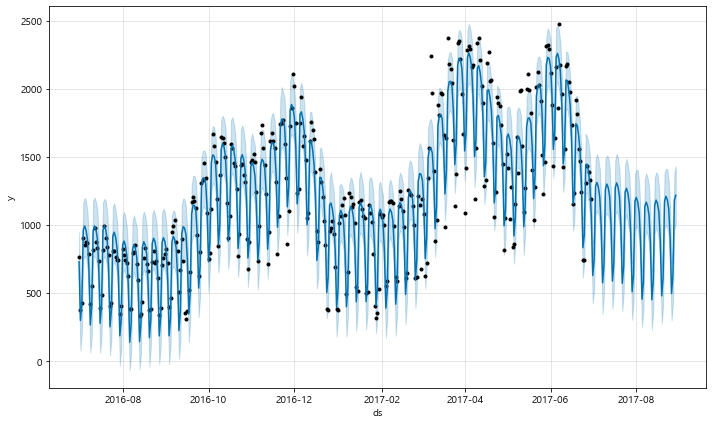

In [13]:
m.plot(forecast);

- ```plot_components()```를 사용해서 **선형 회귀 및 계절성 성분 별로 분해**
    - 다시 말해, **forecast component 시각화(Trend, Holidays, Weakly, Yearly, Daily)**
- Y축이 yearly인 그래프를 살펴보면 3, 6, 10, 12월에 블로그를 찾는 사람들이 많았다. 반면, 1 ~ 2월과 7 ~ 8월에는 블로그 방문자 수가 급격하게 낮은 것을 알 수 있다
    - 이는 대학교의 중간고사, 기말고사, 그리고 방학 시즌과 주기가 비슷하다
    - 저자의 블로그에 공대생들에게 유용한 정보들이 많이 포스팅되어 있다 보니, 이러한 결과가 나온 듯 싶다
    - 역시 대부분(?)의 학생들이 시험 기간에만 집중해서 공부를 많이하고, 방학 기간에는 공부를 잘 하지 않나보다 ㅎㅎ

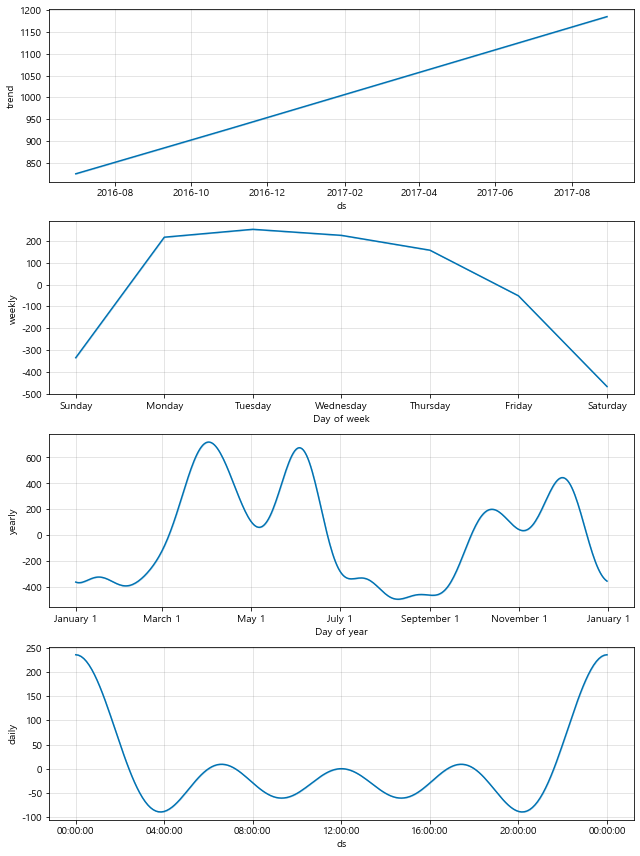

In [14]:
m.plot_components(forecast);

**여기까지 해서 간단한 Seasonal 시계열 분석을 수행해보았다. 학부 때 흥미롭게 배웠던 시계열 분석을 오랜만에 다시 해보니, 역시나 재밌다 ^^**

**이제 본격적으로 주식 데이터에 대해 Seasonal 시계열 분석을 수행해보겠다!!**

## Seasonal 시계열 분석으로 주식 데이터 분석하기
- Pandas는 구글이 제공하는 주가 정보를 받아올 수 있는 기능이 있다
- 종목 코드를 알면 한국 KOSPI 주가 정보도 받아올 수 있다
    - 하지만 현재 **구글이든 야후든 pandas의 주식 데이터를 읽어오는데 문제가 있다**
        - 아래의 코드들은 동작이 되지 않는다...
        - **ex) KIA = web.DataReader('KRX:000270', 'google', start, end)**
        - **ex) KIA = web.DataReader('000270.KS', 'yahoo', start, end)**
    - 이 문제를 해결하기 위한 방법으로, cmd 창에서 아래의 모듈을 설치해주어야 한다 (```fix_yahoo_finance``` 모듈명이 변경되었으므로, ```pip install fix_yahoo_finance```라고 치면 안된다!!)
        - ```pip install yfinance --upgrade --no-cache-dir```로 모듈 설치
        - ```import yfinance as yf```로 import

**'기아자동차(000270)'의 2003년 1월 1일부터 2017년 6월 30일까지의 주가 정보를 사용하겠다**

In [15]:
from pandas_datareader import data
import yfinance as yf
yf.pdr_override()

start_date = '1990-1-1'
end_date = '2017-6-30'

KIA = data.get_data_yahoo('000270.KS', start_date, end_date)
KIA.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-06-18,79400.0,80500.0,79300.0,80000.0,80000.0,1758207
2012-06-19,80000.0,80400.0,79500.0,80000.0,80000.0,1075002
2012-06-20,80900.0,81000.0,79600.0,80000.0,80000.0,885863
2012-06-21,79700.0,80300.0,78700.0,78800.0,78800.0,787586
2012-06-22,77900.0,78200.0,77200.0,77500.0,77500.0,1091383


- **종가(Close)**를 기준으로 그래프를 그려보았다
    - 2012년 이후로 하락하고 있는 추세이다

<참고>
- 종가: 주식거래의 당일 맨 마지막 거래가 체결된 가격

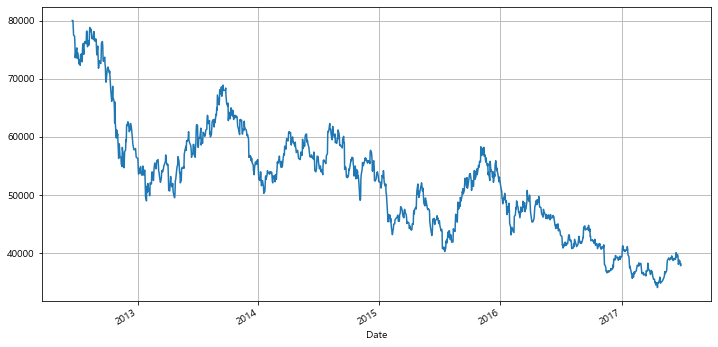

In [16]:
KIA['Close'].plot(figsize = (12, 6), grid = True);

- 나중에 실제 값과의 비교를 위해, 일부 데이터를 잘라서 먼저 forecast를 수행해보겠다

In [17]:
KIA_trunc = KIA[:'2016-12-31']
KIA_trunc

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-06-18,79400.0,80500.0,79300.0,80000.0,80000.0,1758207
2012-06-19,80000.0,80400.0,79500.0,80000.0,80000.0,1075002
2012-06-20,80900.0,81000.0,79600.0,80000.0,80000.0,885863
2012-06-21,79700.0,80300.0,78700.0,78800.0,78800.0,787586
2012-06-22,77900.0,78200.0,77200.0,77500.0,77500.0,1091383
...,...,...,...,...,...,...
2016-12-23,38700.0,39350.0,38650.0,39100.0,39100.0,1070783
2016-12-26,39100.0,39350.0,38850.0,39000.0,39000.0,465612
2016-12-27,39050.0,39700.0,39050.0,39500.0,39500.0,879686


In [18]:
df = pd.DataFrame({'ds': KIA_trunc.index, 'y': KIA_trunc['Close']})
df.reset_index(inplace = True)

# 'ds' 변수를 생성해줬으므로, 'date' 변수는 삭제
del df['Date']

df.head()

,ds,y
0,2012-06-18,80000.0
1,2012-06-19,80000.0
2,2012-06-20,80000.0
3,2012-06-21,78800.0
4,2012-06-22,77500.0


In [19]:
# 주기성이 '일단위(daily_seasonality)'로 있다고 알려준다
m = Prophet(daily_seasonality = True)
m.fit(df);

In [20]:
# 1년(365일) 후. 즉, 2017년 12월 31일까지의 데이터를 예측하겠다는 의미
future = m.make_future_dataframe(periods = 365)
future.tail()

,ds
1482,2017-12-25
1483,2017-12-26
1484,2017-12-27
1485,2017-12-28
1486,2017-12-29


In [21]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1482,2017-12-25,18598.596294,501.305452,37082.731391
1483,2017-12-26,18593.310112,308.465174,37301.813893
1484,2017-12-27,18405.128079,-198.378599,37154.810512
1485,2017-12-28,18199.767031,-216.631454,37400.190698
1486,2017-12-29,17975.530418,-526.002105,37429.652747


- 예측된 부분을 살펴보면, 앞서 수행했던 그래프와 비슷하다는 것을 알 수 있다

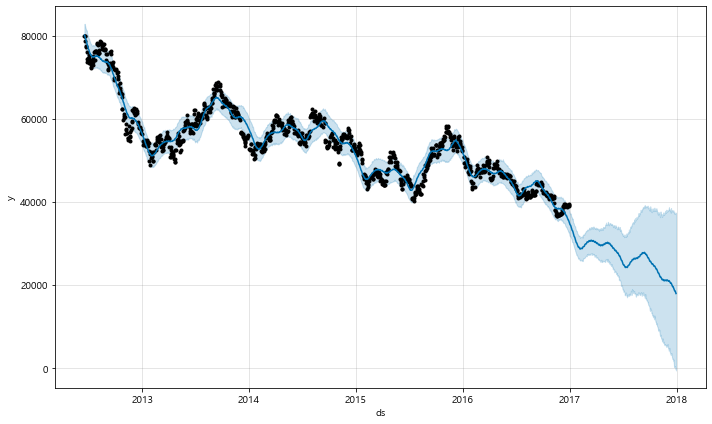

In [22]:
m.plot(forecast);

- 계절성 성분 별로 분해해서 살펴보겠다
    - 먼저 **추세(trend)**를 보면, 예측된 부분이 **반등**되거나 **그대로 내려갈 수도** 있어보인다
    - **주간(weekly)** 데이터를 보면, 주말은 장이 서지 않기 때문에 **화요일**과 **수요일**이 **상대적으로 높은 주가를 유지**하고 있다
    - 마지막으로 **연간(yearly)** 데이터를 살펴보면, 기아자동차의 주가는 1년 중에 **2월에 가장 낮은 주가**를 보이고 **5월에 가장 높은 주가**를 보인다

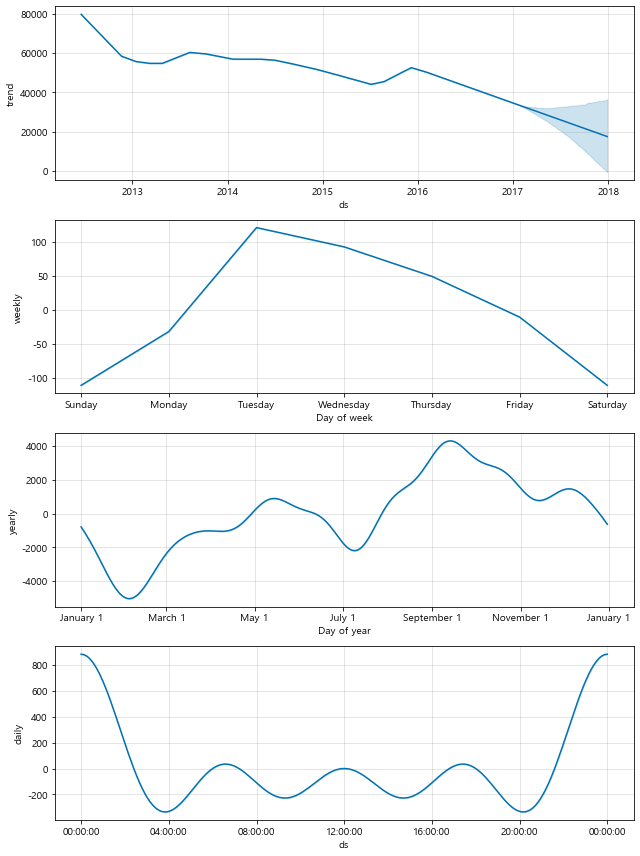

In [23]:
m.plot_components(forecast);

**이번에는 주가를 가져오는 날짜를 변경해서 다시 예측 성능을 확인해보겠다**
- 받아온 데이터는 2017년 7월 31일까지이며, 예측용으로 사용할 데이터는 5월 31일까지로 하겠다
- **종가(Close)**를 기준으로 그래프를 그렸다

[*********************100%***********************]  1 of 1 completed


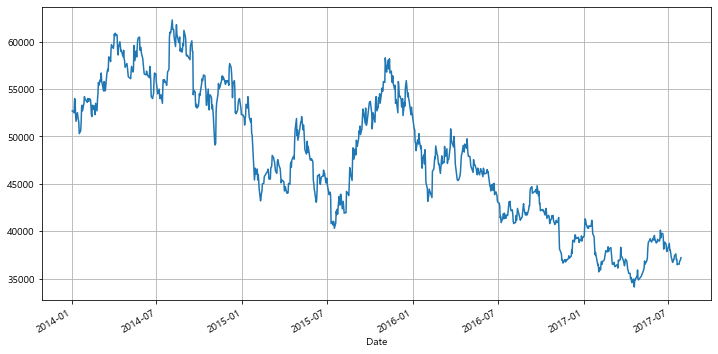

In [24]:
# 받아온 데이터
start_date = '2014-1-1'
end_date = '2017-7-31'

KIA = data.get_data_yahoo('000270.KS', start_date, end_date)

KIA['Close'].plot(figsize = (12, 6), grid = True);

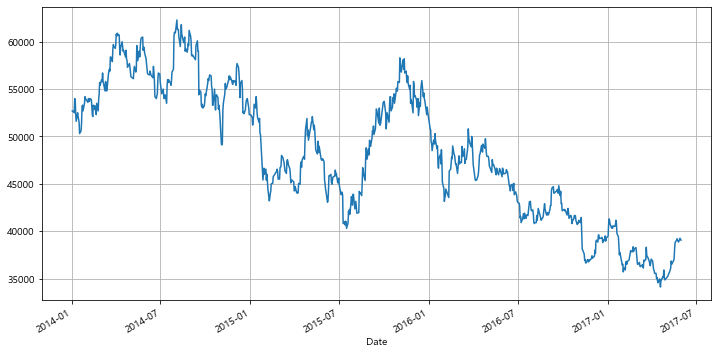

In [25]:
# 예측용으로 사용할 데이터
KIA_trunc = KIA[:'2017-05-31']
KIA_trunc['Close'].plot(figsize = (12, 6), grid = True);

In [26]:
df = pd.DataFrame({'ds': KIA_trunc.index, 'y': KIA_trunc['Close']})
df.reset_index(inplace = True)

# 'ds' 변수를 생성해줬으므로, 'date' 변수는 삭제
del df['Date']

In [27]:
# 주기성이 '일단위(daily_seasonality)'로 있다고 알려준다
m = Prophet(daily_seasonality = True)
m.fit(df);

In [28]:
# 61일 간의 데이터를 예측하겠다는 의미
future = m.make_future_dataframe(periods = 61)
future.tail()

,ds
897,2017-07-27
898,2017-07-28
899,2017-07-29
900,2017-07-30
901,2017-07-31


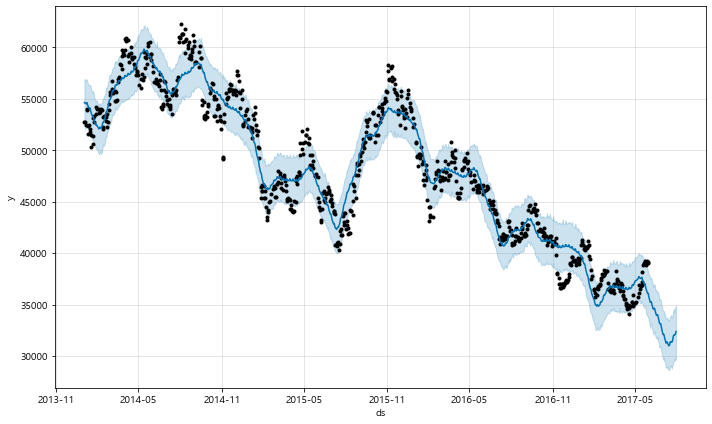

In [29]:
# 예측된 결과를 시각화
forecast = m.predict(future)
m.plot(forecast);

- 그래프를 그려서 실제 데이터 값과 예측 값을 비교!!
    - 예측 값들이 실제 값들과 정확하게 일치하지는 않아도, 어느 정도 비슷한 추세로 예측이 수행되었다는 것을 알 수 있다

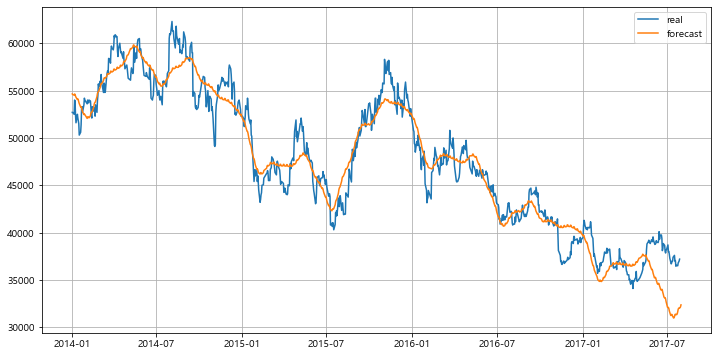

In [30]:
plt.figure(figsize = (12, 6))
plt.plot(KIA.index, KIA['Close'], label = 'real')
plt.plot(forecast['ds'], forecast['yhat'], label = 'forecast')
plt.grid()
plt.legend()
plt.show()

## Growth Model
- 이 부분은 **prophet의 튜토리얼**에 나오는 예제이다
- 예제에서 사용한 데이터는 **주기성**을 띠면서, 점점 성장하는(?) 모습의 데이터이다

In [31]:
df = pd.read_csv("../data/08. example_wp_R.csv")

In [32]:
df.head()

,ds,y
0,2008-01-30,394
1,2008-01-16,424
2,2008-01-17,408
3,2008-01-14,385
4,2008-01-15,369


In [33]:
df['y'] = np.log(df['y']) # 로그 변환
df['cap'] = 8.5           # 예측 값의 상한을 8.5로 설정

df.head()

,ds,y,cap
0,2008-01-30,5.976351,8.5
1,2008-01-16,6.049733,8.5
2,2008-01-17,6.011267,8.5
3,2008-01-14,5.953243,8.5
4,2008-01-15,5.910797,8.5


- 예측 값의 상한이나 하한을 설정했으면, Prophet 객체를 생성할 때 **growth** 파라미터를 설정해주어야 한다
    - 주어진 데이터를 그래프로 그려보면 **'로지스틱 함수'**의 형태와 유사함을 알 수 있으므로, ```growth = 'logistic'``` 이라고 설정해주었다

In [34]:
# 주기성이 '일단위(daily_seasonality)'로 있다고 알려준다
m = Prophet(growth = 'logistic', daily_seasonality = True)
m.fit(df);

- 예측 값의 상한을 8.5로 설정하고, 약 5년(1826일) 간의 데이터를 예측해보겠다

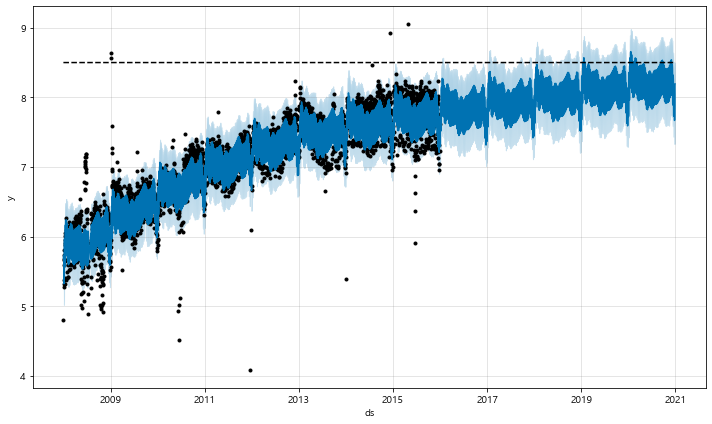

In [35]:
future = m.make_future_dataframe(periods = 1826)
future['cap'] = 8.5

fcst = m.predict(future)
m.plot(fcst);

- 계절성 성분 별로 분해를 살펴보면 다음과 같다
    - 단순히 연습용으로 만들어놓은 데이터를 사용했으므로, 따로 해석하진 않겠다

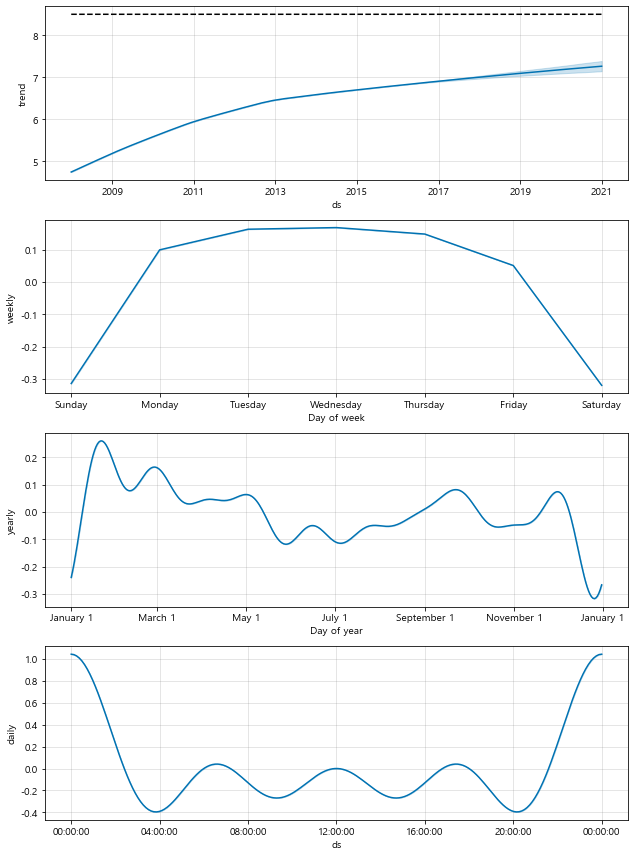

In [36]:
m.plot_components(fcst);

## Holiday Forecast
- **휴일**이나 **모델에 반영하고 싶은 이벤트**가 있으면, Dataframe을 생성해 반영할 수 있다
    - Prophet 객체를 생성할 때, **holidays** 파라미터를 사용하면 된다

In [37]:
df = pd.read_csv("../data/08. example_wp_peyton_manning.csv")
df.head()

,ds,y
0,2007-12-10,14629
1,2007-12-11,5012
2,2007-12-12,3582
3,2007-12-13,3205
4,2007-12-14,2680


In [38]:
df['y'] = np.log(df['y']) # 로그 변환
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [39]:
# 주기성이 '일단위(daily_seasonality)'로 있다고 알려준다
m = Prophet(daily_seasonality = True)
m.fit(df)

# 366일 간의 데이터를 예측해보려 한다
future = m.make_future_dataframe(periods = 366)

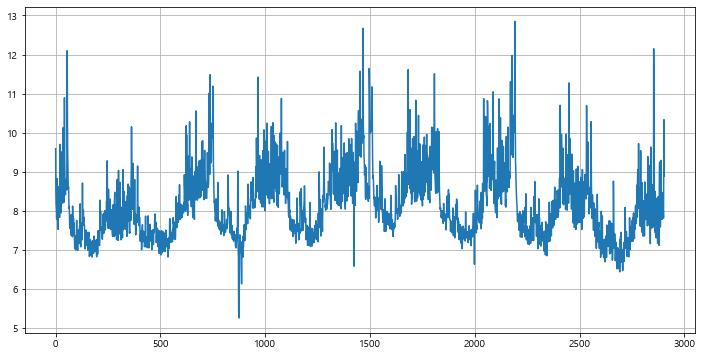

In [40]:
df.y.plot(figsize = (12, 6), grid = True)

**예제용 데이터 프레임을 하나 만들겠다**
- 각각 4개의 변수를 갖는 **playoffs** DataFrame과 **superbowls** DataFrame을 합쳐서(concat), **holidays**라는 DataFrame을 생성하였다

In [41]:
playoffs = pd.DataFrame({'holiday': 'playoff',
                         'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                                               '2010-01-24', '2010-02-07', '2011-01-08',
                                               '2013-01-12', '2014-01-12', '2014-01-19',
                                               '2014-02-02', '2015-01-11', '2016-01-17',
                                               '2016-01-24', '2016-02-07']),
                         'lower_window': 0,
                         'upper_window': 1})

superbowls = pd.DataFrame({'holiday': 'superbowl',
                           'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
                           'lower_window': 0,
                           'upper_window': 1})

holidays = pd.concat((playoffs, superbowls))
holidays.head()

,holiday,ds,lower_window,upper_window
0,playoff,2008-01-13,0,1
1,playoff,2009-01-03,0,1
2,playoff,2010-01-16,0,1
3,playoff,2010-01-24,0,1
4,playoff,2010-02-07,0,1


- Prophet 객체를 생성할 때, ```holidays``` 파라미터를 사용

In [42]:
m = Prophet(holidays = holidays, daily_seasonality = True)
forecast = m.fit(df).predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2007-12-10,9.267709,8.262285,9.478496,9.267709,9.267709,-0.426693,-0.426693,-0.426693,-1.223359,...,0.329649,0.329649,0.329649,0.467017,0.467017,0.467017,0.0,0.0,0.0,8.841016
1,2007-12-11,9.266085,8.041002,9.219123,9.266085,9.266085,-0.637605,-0.637605,-0.637605,-1.223359,...,0.133019,0.133019,0.133019,0.452734,0.452734,0.452734,0.0,0.0,0.0,8.628480
2,2007-12-12,9.264461,7.869965,9.013316,9.264461,9.264461,-0.837233,-0.837233,-0.837233,-1.223359,...,-0.053214,-0.053214,-0.053214,0.439339,0.439339,0.439339,0.0,0.0,0.0,8.427228
3,2007-12-13,9.262837,7.837415,8.997896,9.262837,9.262837,-0.855408,-0.855408,-0.855408,-1.223359,...,-0.059223,-0.059223,-0.059223,0.427173,0.427173,0.427173,0.0,0.0,0.0,8.407429
4,2007-12-14,9.261213,7.834914,9.030600,9.261213,9.261213,-0.863154,-0.863154,-0.863154,-1.223359,...,-0.056332,-0.056332,-0.056332,0.416537,0.416537,0.416537,0.0,0.0,0.0,8.398059


In [43]:
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
2190,2014-02-02,1.224116,1.203719
2191,2014-02-03,1.902824,1.458890
2532,2015-01-11,1.224116,0.000000
2533,2015-01-12,1.902824,0.000000
2901,2016-01-17,1.224116,0.000000
2902,2016-01-18,1.902824,0.000000
2908,2016-01-24,1.224116,0.000000
2909,2016-01-25,1.902824,0.000000
2922,2016-02-07,1.224116,1.203719
2923,2016-02-08,1.902824,1.458890


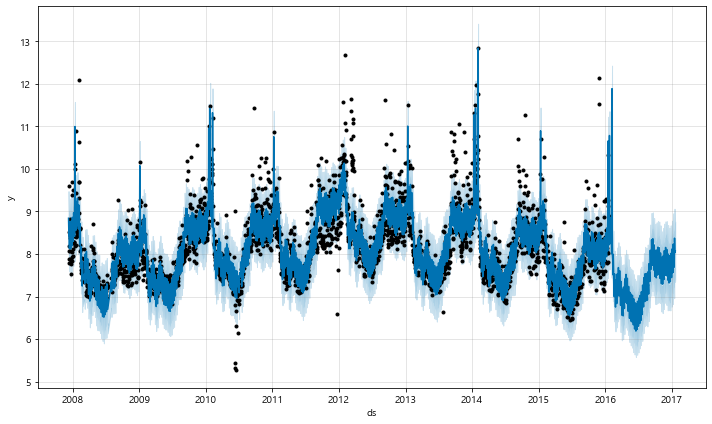

In [44]:
m.plot(forecast);

- 다음과 같이, 계절성 성분 별로 분해를 한 결과에서 holidays의 영향도 확인할 수 있다

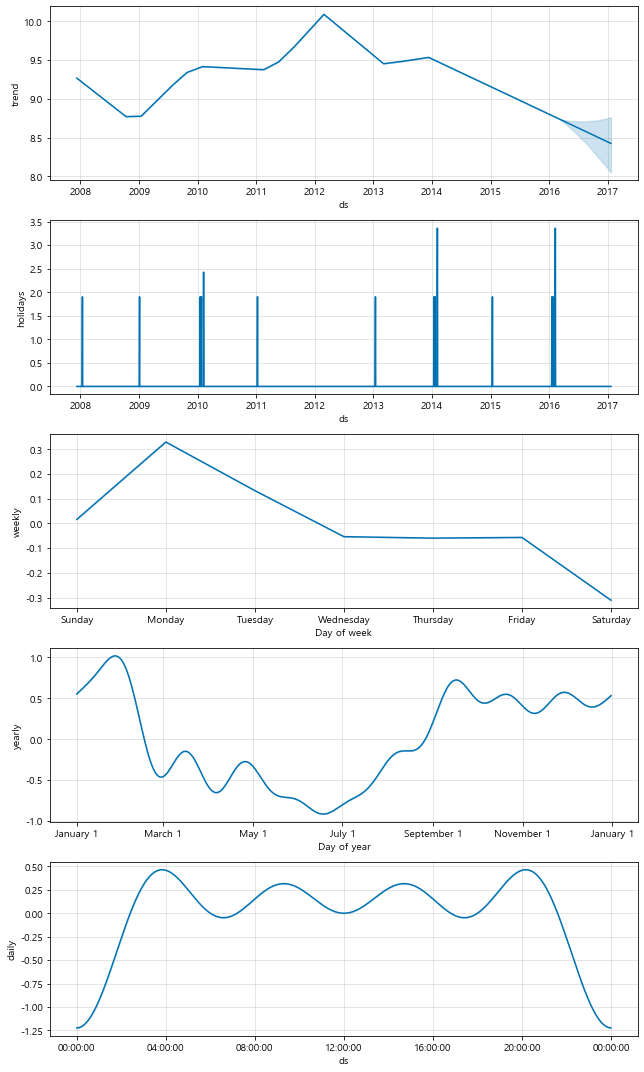

In [45]:
m.plot_components(forecast);

**<7장을 마치며...>**
- 평소 시계열 분석에 대해 많은 관심을 갖고 있던 나로서는, 이번 챕터가 정말 정말 흥미로웠다
- 비록 학부 수준에서 배운 **AR, MA, ARMA, ARIMA, SARIMA** 모형이 전부이지만, 기회가 된다면 **ARCH, GARCH**와 같은 좀 더 deep한 모형들에 대해서도 공부해보고 싶다!
- 재밌었던 시계열 분석 끝!!